# Geospatial Data: Street Networks

thanks to @Nick Hand for the lecture!

In [1]:
# Imports
import altair as alt
import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Show all columns in dataframes
pd.options.display.max_columns = 999

In [3]:
# Hide warnings due to issue in shapely package 
# See: https://github.com/shapely/shapely/issues/1345
np.seterr(invalid="ignore");

https://www.openstreetmap.org

## Working with OSM data

- Raw data is very messy
- Two relatively new, amazing Python packages greatly simply the process
- Related, but complementary features    
    - **OSMnx:** downloading and manipulating streets as networks
    - **Pandana:** networks focused on accessibility of amenities
    
**Related:** interactive web maps in Python

## OSMnx

Relatively new package (just a few years old), but quickly becoming the go to package for working with street networks and OpenStreetMap data in Python.

Several key features: 

- Downloading political boundaries for cities, states, countries, etc
- Downloading street networks
- Analyzing networks: routing, visualization, statistics

  - [GitHub](https://github.com/gboeing/osmnx)
  - [Introductory Blog Post](https://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [Jupyter Notebook Examples](https://github.com/gboeing/osmnx-examples/tree/master/notebooks) ([Binder](https://mybinder.org/v2/gh/gboeing/osmnx-examples/main?urlpath=/tree/notebooks))
  - [Documentation](https://osmnx.readthedocs.io)

In [4]:
import osmnx as ox

### 1.1. Getting boundary shapefiles from OSM

Key function: `geocode_to_gdf()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.geocoder.geocode_to_gdf))

We can get the boundary for anything identified as a "place" by OSM.

**Important: Be careful to pass the right place name that OSM needs**

In [5]:
bru = ox.geocode_to_gdf("Brussels-Capital")
bbox = bru.total_bounds  # [minx, miny, maxx, maxy]
bru.head()

geometry  bbox_north  bbox_south  \
0  POLYGON ((4.24377 50.81958, 4.24438 50.81954, ...   50.913905    50.76368   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0   4.482271   4.243766  122277842  relation   54094  50.838795  4.375304   

      class            type  place_rank  importance addresstype  \
0  boundary  administrative           6    0.705961      region   

               name               display_name  
0  Brussels-Capital  Brussels-Capital, Belgium

In [7]:
#bru.crs #indicates the projection, likely WGS84

Getting bounding box for Brussels outer limits (we will need it later)

In [8]:
bbox = bru.total_bounds  # [minx, miny, maxx, maxy]
print(bbox)

[ 4.2437658 50.7636799  4.4822711 50.9139045]


We can plot Brussels boundary just like any other GeoDataFrame

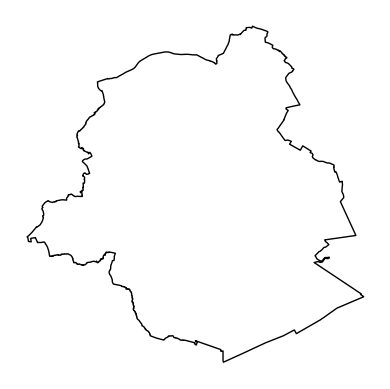

In [9]:
# Project it to Web Mercator first and plot
ax = bru.to_crs(epsg=3857).plot(facecolor="none", edgecolor="black")
ax.set_axis_off()

### 1.2 Projecting with OSMnx

Key function: `project_gdf()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.projection.project_gdf))

Automatically projects to the [Universal Transverse Mercator](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) (UTM) CRS for the UTM zone that the centroid of the polygon lies in 

A good, general projection that works for most latitudes except very northern locations.

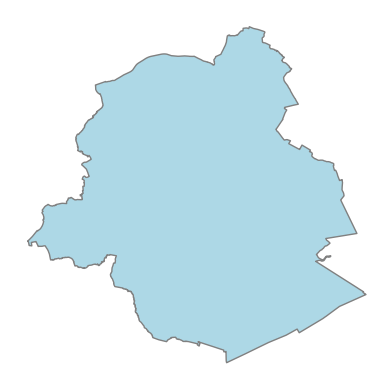

In [10]:
ax = ox.project_gdf(bru).plot(fc="lightblue", ec="gray")
ax.set_axis_off()

### 1.3 Downloading OSM features

Key functions: `features_from_*`

- `features_from_place()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.features.features_from_place))
     - Download features within an OSM place boundary
- `features_from_address()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.features.features_from_address))
    - Download features within a certain distance of an address
- `features_from_bbox()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.features.features_from_bbox))
    - Download features within a N, S, E, W bounding box
- `features_from_point()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.features.features_from_point)) 
    - Download features within a certain distance of a specified point
- `features_from_polygon()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.features.features_from_polygon))
    - Download features within a polygon object

#### About OSM features

**Important reference:** https://wiki.openstreetmap.org/wiki/Map_Features

- OSM uses a *tagging* system to categorize different map features
- The main feature categories are available on the OSM Wikipedia
    - Examples: 'amenity', 'building', 'landuse', 'highway'
- There are specific sub-categories for each feature type too:
    - Amenity examples: 'bar', 'college', 'library'

In the language of OSM, the "key" is the main feature category (e.g., amenity) and the "value" is the sub-category type (e.g., "bar")

`osmnx` mirrors the key/value syntax of OSM. Use a dict to specify the features you want: 

In [11]:
# Get all amenities in Brussels
amenities = ox.features_from_place("Brussels, Belgium", tags={"amenity": True})

In [34]:
len(amenities)

7211

In [35]:
amenities.head()

amenity bicycle_parking capacity covered  \
element_type osmid                                                          
node         26084977    bicycle_parking          stands       10      no   
             123526818  parking_entrance             NaN      NaN     NaN   
             183077379    bicycle_rental             NaN       30     NaN   
             192578075          pharmacy             NaN      NaN     NaN   
             234559687    bicycle_rental             NaN       25     NaN   

                               mapillary                  geometry foot  \
element_type osmid                                                        
node         26084977   7645034965611407  POINT (4.37429 50.81855)  NaN   
             123526818               NaN  POINT (4.35245 50.83820)   no   
             183077379               NaN  POINT (4.35569 50.83588)  NaN   
             192578075               NaN  POINT (4.35551 50.85284)  NaN   
             234559687               NaN  POINT (4.35306 50.83791)  NaN   

                       maxheight      parking entrance   bicycle_rental  \
element_type osmid                                                        
node         26084977        NaN          NaN      NaN              NaN   
             123526818         2  underground      NaN              NaN   
             183077379       NaN          NaN      NaN  docking_station   
             192578075       NaN          NaN      NaN              NaN   
             234559687       NaN          NaN      NaN  docking_station   

                         brand brand:wikidata brand:wikipedia  \
element_type osmid                                              
node         26084977      NaN            NaN             NaN   
             123526818     NaN            NaN             NaN   
             183077379  Villo!       Q2510744       en:Villo!   
             192578075     NaN            NaN             NaN   
             234559687  Villo!       Q2510744       en:Villo!   

                                   name name:fr name:nl network  \
element_type osmid                                                
node         26084977               NaN     NaN     NaN     NaN   
             123526818              NaN     NaN     NaN     NaN   
             183077379  Louise - Louiza  Louise  Louiza  Villo!   
             192578075          Deroisy     NaN     NaN     NaN   
             234559687         Poelaert     NaN     NaN  Villo!   

                       network:wikidata network:wikipedia  operator  \
element_type osmid                                                    
node         26084977               NaN               NaN       NaN   
             123526818              NaN               NaN       NaN   
             183077379         Q2510744         en:Villo!  JCDecaux   
             192578075              NaN               NaN       NaN   
             234559687         Q2510744         en:Villo!  JCDecaux   

                       operator:wikidata operator:wikipedia  ref survey:date  \
element_type osmid                                                             
node         26084977                NaN                NaN  NaN         NaN   
             123526818               NaN                NaN  NaN         NaN   
             183077379            Q74877        fr:JCDecaux   16  2018-12-27   
             192578075               NaN                NaN  NaN         NaN   
             234559687            Q74877        fr:JCDecaux   37         NaN   

                                      website wheelchair dispensing  \
element_type osmid                                                    
node         26084977                     NaN        NaN        NaN   
             123526818                    NaN        NaN        NaN   
             183077379  https://www.villo.be/         no        NaN   
             192578075                    NaN        NaN        yes   
             234559687  https:

#### Other example: retrieving bars, restaurant, cafe and coffee_shop

In [12]:
# Define the tags for the amenities you want to retrieve
tags = {
    "amenity": ["bar", "restaurant", "cafe", "coffee_shop"]
}

# Get all the amenities in Brussels
places = ox.features_from_place("Brussels-Capital", tags=tags)
len(places)
# Display the data
#print(places.head())

2667

In [13]:
places.head()

amenity           contact:email    contact:phone  \
element_type osmid                                                            
node         234494737  restaurant  chatelain@mammaroma.be  +32 2 544 14 02   
             234524306  restaurant     info@ultimeatome.be  +32 2 513 48 84   
             234524310  restaurant                     NaN  +32 2 511 11 21   
             305178282  restaurant                     NaN              NaN   
             306122013  restaurant                     NaN              NaN   

                                       contact:website        cuisine  \
element_type osmid                                                      
node         234494737       https://www.mammaroma.be/          pizza   
             234524306      https://www.ultimeatome.be            NaN   
             234524310  https://www.leclandesbelges.be          local   
             305178282                             NaN            NaN   
             306122013                             NaN  pizza;italian   

                       diet:vegan diet:vegetarian                name  \
element_type osmid                                                      
node         234494737         no             yes          Mamma Roma   
             234524306        NaN             NaN      L'Ultime Atome   
             234524310        NaN             NaN  Le clan des Belges   
             305178282        NaN             NaN          Le Médicis   
             306122013         no             yes          Mamma Roma   

                                               opening_hours    operator  \
element_type osmid                                                         
node         234494737  Su-We 12:00-22:00; Th-Sa 12:00-22:30  Mamma Roma   
             234524306  Su-Th 08:00-00:30; Fr-Sa 08:00-01:00         NaN   
             234524310                                   NaN         NaN   
             305178282                                   NaN         NaN   
             306122013  Mo-Su 12:00-22:00; Th-Sa 12:00-22:30         NaN   

                                        geometry contact:facebook  \
element_type osmid                                                  
node         234494737  POINT (4.35932 50.82403)              NaN   
             234524306  POINT (4.36441 50.83593)   UltimeAtome.be   
             234524310  POINT (4.36481 50.83561)              NaN   
             305178282  POINT (4.46339 50.83856)              NaN   
             306122013  POINT (4.37112 50.82758)              NaN   

                       contact:instagram internet_access internet_access:fee  \
element_type osmid                                                             
node         234494737               NaN             NaN                 NaN   
             234524306    _ultime_atome_            wlan                  no   
             234524310               NaN            wlan                 NaN   
             305178282               NaN             NaN                 NaN   
             306122013               NaN             NaN                 NaN   

                       outdoor_seating   smoking wheelchair  \
element_type osmid                                            
node         234494737             NaN       NaN        NaN   
             234524306             yes  isolated         no   
             234524310             yes       NaN    limited   
             305178282             NaN       NaN        NaN   
             306122013             NaN       NaN         no   

                                            brewery alt_name start_date  \
element_type osmid                                                        
node         234494737                          NaN      NaN        NaN   
             234524306                          NaN      NaN        NaN   
             234524310  Chouffe;Vedett Blanche;Maes      NaN        NaN   
             305178282                          NaN   

Let's plot the land use features:

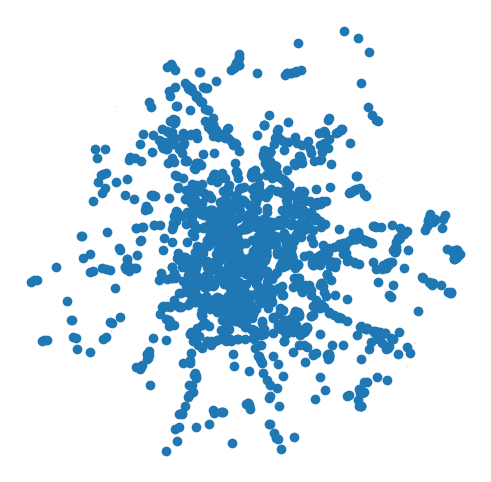

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = places.plot(ax=ax)
ax.set_axis_off()

#### Street network around an address or a region.
**This can take time in populated areas**

Get streets within 15000 meters of the center of Center City, and plot it.

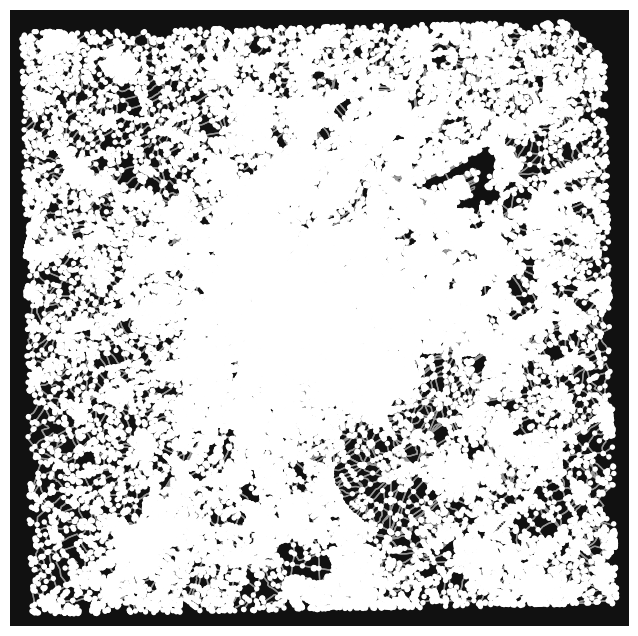

In [16]:
G = ox.graph_from_address("Brussels-Capital", dist=15000)
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected);

Remove the nodes:

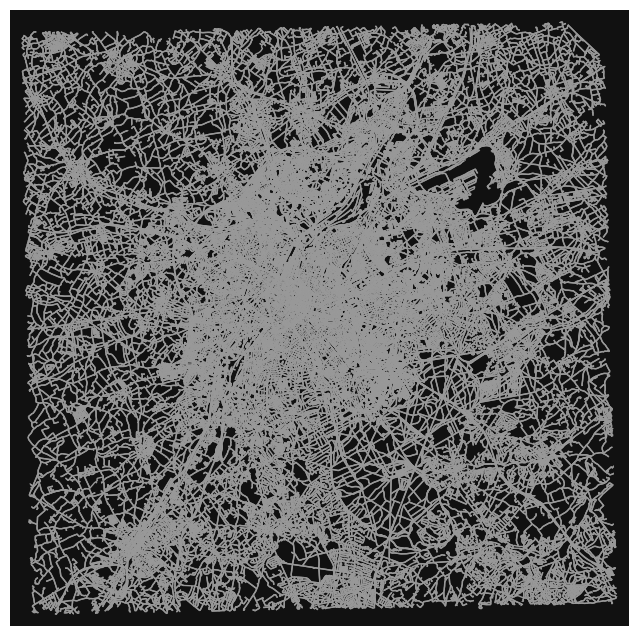

In [17]:
ox.plot_graph(G_projected, node_size=0);

#### Getting different network types

- `drive` - get drivable public streets (but not service roads)
- `drive_service` - get drivable streets, including service roads
- `walk` - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
- `bike` - get all streets and paths that cyclists can use
- `all` - download all non-private OSM streets and paths
- `all_private` - download all OSM streets and paths, including private-access ones (default)

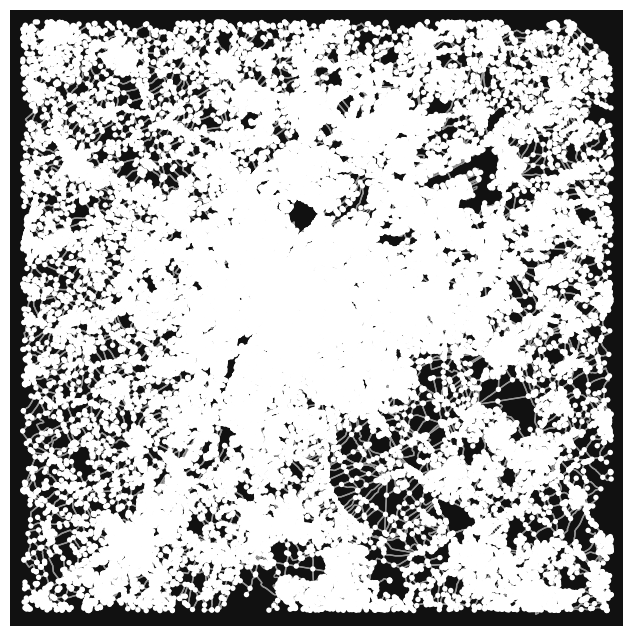

In [18]:
G = ox.graph_from_address("Brussels-Capital", dist=15000, dist_type='bbox', 
                               network_type='bike', simplify=True)

ox.plot_graph(G);

In [19]:
# Convert the graph to GeoDataFrames (nodes and edges)
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# Truncate column names to 10 characters (for ESRI Shapefile compatibility)
gdf_nodes.columns = [col[:10] for col in gdf_nodes.columns]
gdf_edges.columns = [col[:10] for col in gdf_edges.columns]

# Remove columns with unsupported data types (like lists)
# Find and drop columns with lists or unsupported types
gdf_edges = gdf_edges[[col for col in gdf_edges.columns if gdf_edges[col].apply(lambda x: isinstance(x, (list, dict))).sum() == 0]]
gdf_nodes = gdf_nodes[[col for col in gdf_nodes.columns if gdf_nodes[col].apply(lambda x: isinstance(x, (list, dict))).sum() == 0]]

# Save the nodes and edges as shapefiles
gdf_nodes.to_file("brussels__bike_nodes.shp")
gdf_edges.to_file("brussels_bike_edges.shp")

print("Shapefiles for nodes and edges have been saved successfully.")

Shapefiles for nodes and edges have been saved successfully.


Let's check out the street network for Brussels, Belgium

Squeeze it so we can get the geometry polygon:

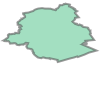

In [60]:
center_city_outline = bru.squeeze().geometry
center_city_outline

Now, let's use `ox.graph_from_polygon()` to extract streets within this polygon. 

### 1.5 Converting from a graph to a GeoDataFrame

Key function: `ox.graph_to_gdfs()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=graph_to_gdf#osmnx.utils_graph.graph_to_gdfs))

You can get a GeoDataFrame for both the nodes (points) and edges (lines)

In [20]:
# only get the edges
cc_edges = ox.graph_to_gdfs(G, edges=True, nodes=False)

In [96]:
# we have lots of data associated with each edge!
#cc_edges.head()

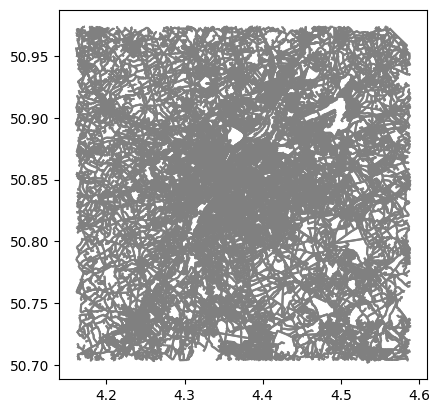

In [21]:
ax = cc_edges.plot(color="gray")

NameError: name 'center_city_outline' is not defined

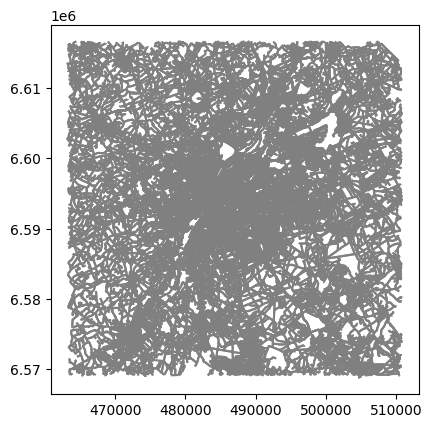

In [22]:
# plot it like any old GeoDataFrame
ax = cc_edges.to_crs(epsg=3857).plot(color="gray")

# add the neighborhood boundaries
boundary = gpd.GeoSeries([center_city_outline], crs="EPSG:4326")
boundary.to_crs(epsg=3857).plot(
    ax=ax, facecolor="none", edgecolor="red", linewidth=3, zorder=2
)

ax.set_axis_off()

**Don't forget:** We can use the `.explore()` function to get an interactive web map via Folium:

In [74]:
#cc_edges.explore(tiles='cartodb positron')

### Cool option: Finding the shortest route

Let's calculate a shortest route between [the main square (grand-place) ](https://www.openstreetmap.org/node/1635651356) to the [airport](https://www.openstreetmap.org/node/3202279605).

You just need the coordinates of the origin, destination, and the network you are using. In the `weight` section, you can specify the impedence.

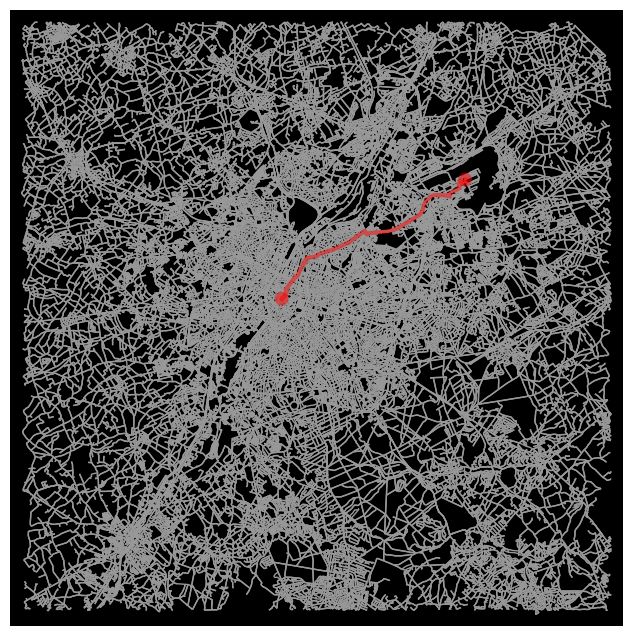

In [23]:
import networkx as nx

# Step 2: Define the coordinates for the origin (e.g., Main Square) and destination (e.g., Airport)
origin_point = (50.8467, 4.3499)  # Coordinates for Grand Place, Brussels (Main Square)
destination_point = (50.9014, 4.4844)  # Coordinates for Brussels Airport

# Step 3: Find the nearest nodes to these coordinates
orig_node = ox.distance.nearest_nodes(G, X=origin_point[1], Y=origin_point[0])
dest_node = ox.distance.nearest_nodes(G, X=destination_point[1], Y=destination_point[0])

#ox.nearest_nodes?

# Step 4: Calculate the shortest route between these nodes using 'length' (distance)
shortest_route = nx.shortest_path(G, orig_node, dest_node, weight='length')

# Step 5: Plot the route
fig, ax = ox.plot_graph_route(G, shortest_route, route_linewidth=3, node_size=0, bgcolor='k')

In [80]:
#shortest_route  -/- will show a list of OSM ids

How about an interactive version?

`osmnx` has a helper function `ox.utils_graph.route_to_gdf()` to convert a route to a GeoDataFrame of edges.

In [82]:
ox.utils_graph.route_to_gdf(G, shortest_route, weight="length").explore(
    tiles="cartodb positron",
    color="red",
)

#### Finding the shortest travel time


The `add_edge_speeds` function add edge speeds (km per hour) to graph as new `speed_kph` edge attributes. 

The function will add free-flow travel speeds for all edges based on the average `maxspeed` value of edges, per highway type. This process can definitely be imprecise, but in the case that you happen to have more precise speed data, you can supply your own data instead of relying on OSM data. 

In [83]:
# impute speed on all edges missing data
G = ox.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

In [84]:
# Get the graph edges
edges = ox.graph_to_gdfs(G, nodes=False)

In [85]:
#edges.head()

In [86]:
# calculate two routes by minimizing travel time
route2 = ox.shortest_path(G, orig_node, dest_node, weight="travel_time")

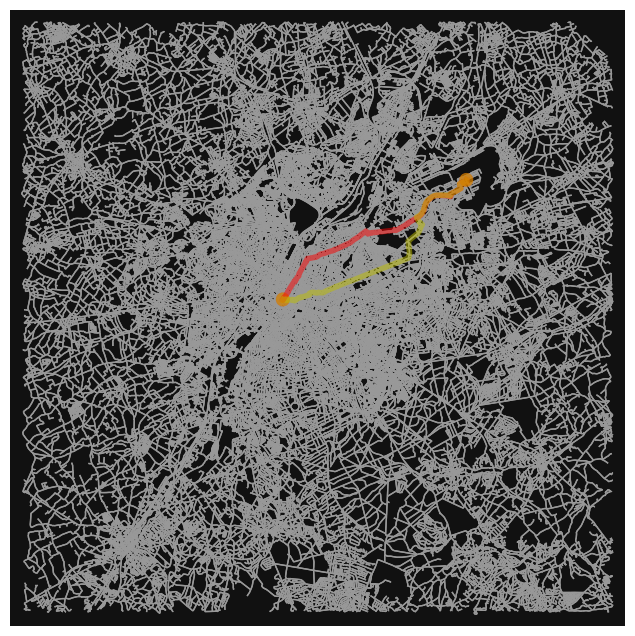

In [88]:
# plot the routes
fig, ax = ox.plot_graph_routes(
    G,
    routes=[shortest_route, route2],
    route_colors=["r", "y"],
    route_linewidth=6,
    node_size=0,
)

Let's plot both in an interactive map:

In [89]:
m = ox.utils_graph.route_to_gdf(G, shortest_route, weight="length").explore(
    tiles="cartodb dark matter",
    color="red",
)

m = ox.utils_graph.route_to_gdf(G, route2, weight="length").explore(
    tiles="cartodb dark matter",
    color="yellow",
    m=m
)
m

Let's compare to the two routes:

Distances:

In [90]:
meters_to_miles = 0.0006213712

# compare the two routes
route1_length = (
    ox.utils_graph.route_to_gdf(G, shortest_route, weight="length")["length"].sum()
    * meters_to_miles
)

route2_length = (
    ox.utils_graph.route_to_gdf(G, route2, weight="length")["length"].sum()
    * meters_to_miles
)

Travel times:

In [97]:
seconds_to_mins = 1.0 / 60

route1_time = (
    ox.utils_graph.route_to_gdf(G, shortest_route, weight="travel_time")["travel_time"].sum()
    * seconds_to_mins
)
route2_time = (
    ox.utils_graph.route_to_gdf(G, route2, weight="travel_time")["travel_time"].sum()
    * seconds_to_mins
)

Summarize:

In [93]:
print(f"Route 1 is {route1_length:.2f} miles and takes {route1_time:.2f} minutes.")
print(f"Route 2 is {route2_length:.2f} miles and takes {route2_time:.2f} minutes.")

Route 1 is 7.96 miles and takes 21.52 minutes.
Route 2 is 8.39 miles and takes 20.21 minutes.
